In [1]:
%load_ext lab_black

In [2]:
import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

sns.set()

# Last night, I was visited in my dreams by The Welsh Dragon!

### "Use these", they said...

In [3]:
train_features = pd.read_csv("data/train_features.csv")  # 5,000 features!
train_target = pd.read_csv("data/train_target.csv")["target"]  # binary target
test_features = pd.read_csv("data/test_features.csv")

### "to predict this!" it continued.

In [4]:
test_target = pd.read_csv("data/test_target.csv")["target"]

### "But you're only allowed one try!"

# Let's select the 10 features which are most correlated with the target!

In [5]:
best_features = train_features.corrwith(train_target).abs().nlargest(10).index

In [6]:
classifier = LogisticRegression(solver="lbfgs")
classifier.fit(train_features[best_features], train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

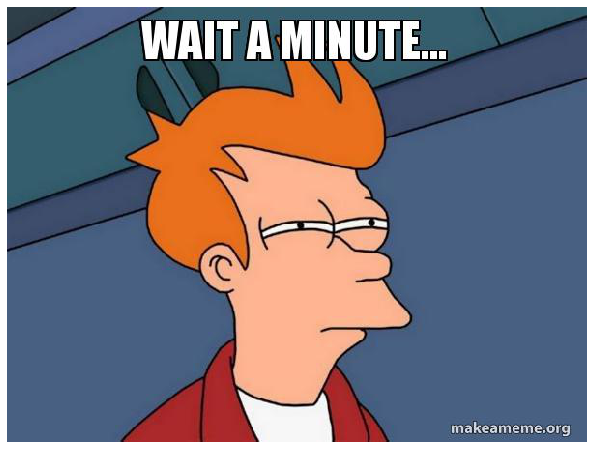

In [7]:
plt.figure(figsize=(12, 8))
img = mpimg.imread("images/wait.jpg")
imgplot = plt.imshow(img)
_ = plt.axis("off")

# Remember, we're only allowed one try!

### So let's do cross-validation first

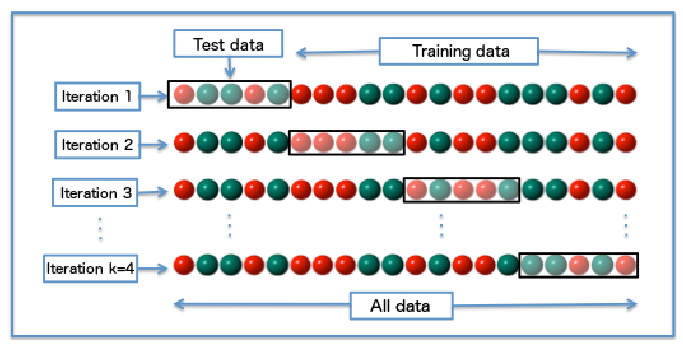

In [8]:
plt.figure(figsize=(12, 8))
img = mpimg.imread("images/K-fold.jpg")
imgplot = plt.imshow(img)
_ = plt.axis("off")

In [9]:
cv = KFold(5)

"Cross-validation score: {}".format(
    cross_val_score(
        classifier,
        train_features[best_features],
        train_target,
        scoring="roc_auc",
        cv=cv,
    ).mean()
)

'Cross-validation score: 0.9087662337662339'

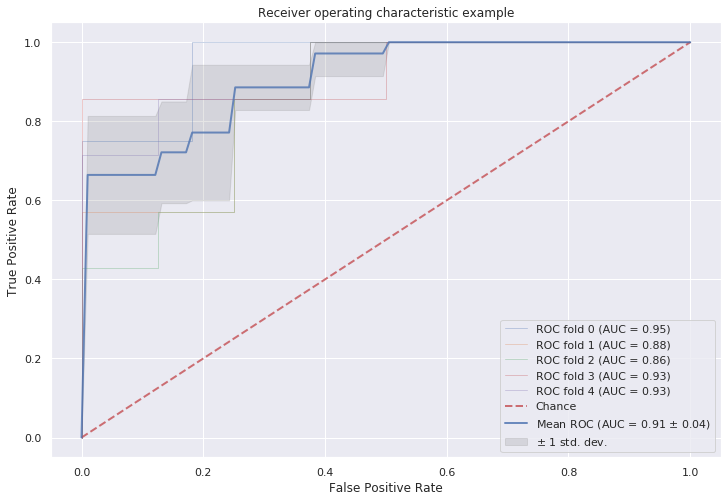

In [10]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(12, 8))
for train, val in cv.split(train_features, train_target):
    probas_ = classifier.fit(
        train_features[best_features].iloc[train], train_target.iloc[train]
    ).predict_proba(train_features[best_features].iloc[val])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_target.iloc[val], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc)
    )

    i += 1
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")

plt.show()

# That's an awesome score!!! Let's use it on the test set, the dragon will be very pleased with us

In [11]:
classifier.fit(train_features[best_features], train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
probabilities = classifier.fit(
    train_features[best_features], train_target
).predict_proba(test_features[best_features])[:, 1]

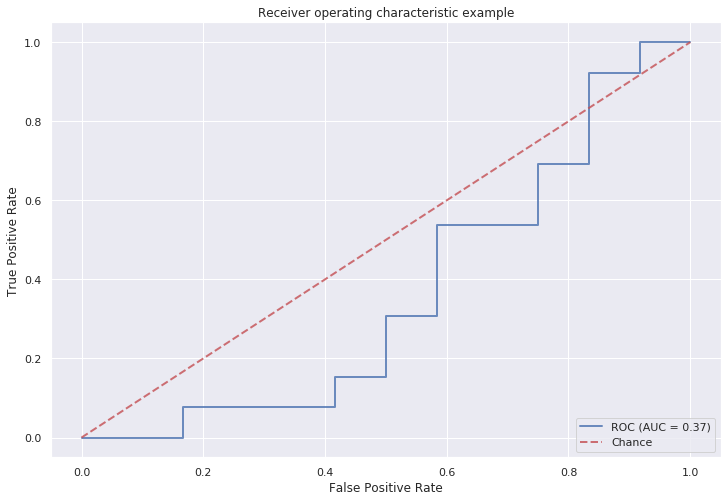

Your score is 0.3653846153846154.


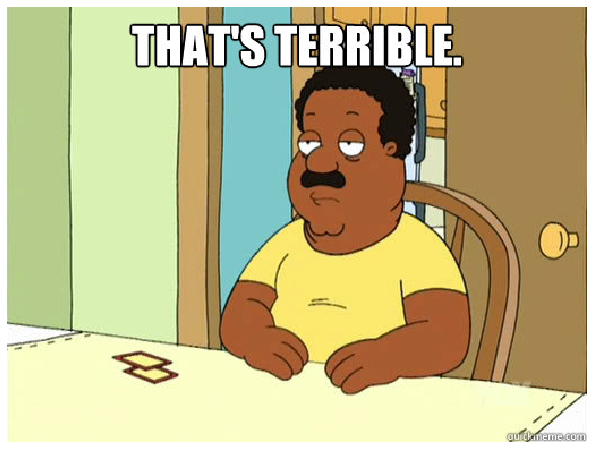

In [13]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(12, 8))
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(test_target, probabilities)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=2, alpha=0.8, label="ROC (AUC = %0.2f)" % (roc_auc))

i += 1
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()
print(f"Your score is {roc_auc}.")

plt.figure(figsize=(12, 8))

img = mpimg.imread("images/terrible.jpg")
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

### Q: What should we have done insteaed?
### A: Do feature selection WITHIN cross-validation!

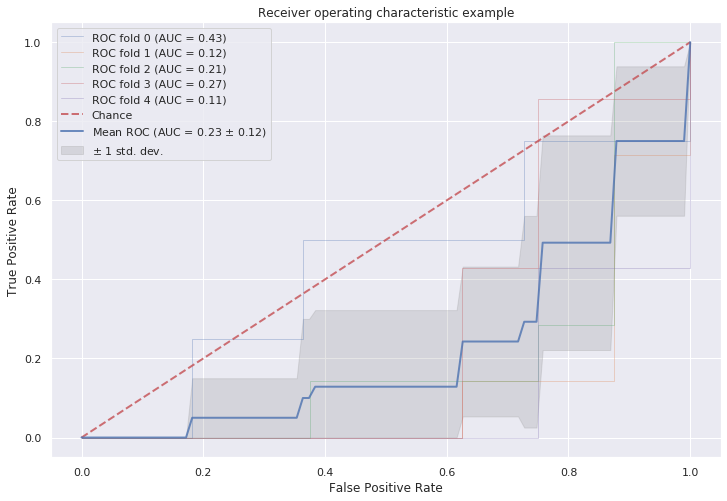

In [14]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(12, 8))
for train, val in cv.split(train_features, train_target):

    best_features = (
        train_features.iloc[train]
        .corrwith(train_target.iloc[train])
        .abs()
        .nlargest(10)
        .index
    )

    probas_ = classifier.fit(
        train_features[best_features].iloc[train], train_target.iloc[train]
    ).predict_proba(train_features[best_features].iloc[val])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_target.iloc[val], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc)
    )

    i += 1
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="upper left")
plt.show()

### ...and like this, we would have known our model was terrible and would have known better than to put it into production.

Credit for this fun example: Chapter 7.10.2 The Wrong and Right Way to Do Cross-validation, _Elements of Statistical Learning_